In [376]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [377]:
class Arm:
    def __init__(self, p):
        self.p = p
    
    def pull(self):
        return np.random.binomial(1, self.p)

class MultiBandit:
    def __init__(self, probs = [0.9, 0.2, 0.7, 0.5]):
        self.__arms = [Arm(p) for p in probs]
        self.__regret = 0
        self.__maxp = max(probs)

    def num_arms(self):
        return len(self.__arms)

    def pull(self, arm_num):
        reward = self.__arms[arm_num].pull()
        self.__regret += self.__maxp-self.__arms[arm_num].p
        return reward
    
    def regret(self):
        return self.__regret
        
    def set_regret(self):
        self.__regret = 0

In [378]:
class ThompsonAlgorithm:
    def __init__(self, num_arms, horizon):
        # Initialize our algorithm
        self.num_arms = num_arms
        self.horizon = horizon
        self.timestep = 0
        self.arm_pulls = np.zeros(num_arms)
        self.arm_rewards = np.zeros(num_arms)
        self.regrets = np.zeros(horizon)
        self.succ_fail = [[self.arm_rewards[j], self.arm_pulls[j] - self.arm_rewards[j]] for j in range(self.num_arms)]

    def give_best_arm(self):
        # Return the arm which the algorithm considers to be the best arm at end of algorithm
        #print(self.succ_fail)
        samples = [np.random.beta(s+1, f+1) for s, f in self.succ_fail]  # add 1 because can't pass 0
        #print(samples)
        #Pick the arm with the highest sampled estimate
        maxval = max(samples)
        ind = [index for index, value in enumerate(samples) if value == maxval]
        if len(ind) > 1: 
            b = ind[random.randrange(len(ind))]
        else:
            b = ind[0]  
        #print(b)
        return b

    def run_algorithm(self, bandit):
        for _ in range(self.horizon):
            arm_to_pull = self.give_best_arm()          # Select the arm using the algorithm
            reward = bandit.pull(arm_to_pull)           # Pull the arm and find our the reward
            self.arm_pulls[arm_to_pull] += 1            # Update the arm pull count and arm reward count
            self.arm_rewards[arm_to_pull] += reward
            self.timestep += 1                          # Update the timestep
            self.succ_fail = [[self.arm_rewards[j], self.arm_pulls[j] - self.arm_rewards[j]] for j in range(self.num_arms)]
            self.regrets[_] = bandit.regret() 

    def plot(self):
        # Plot the regret graph. Label the X and Y Axis properly using matplotlib library
        plt.plot(range(0, self.horizon), self.regrets, label='Regret')
        plt.ylabel('Regret')
        plt.xlabel('Timestep')  # Fix: Correct method is plt.xlabel
        plt.legend()
        plt.title('Regret over timestep')
        plt.show()

In [379]:
class UCB:
    def __init__(self, num_arms, horizon):
        # Initialize our algorithm
        self.num_arms = num_arms                    # Number of arms present in the bandit
        self.horizon = horizon                      # Total Horizon of the algorithm
        self.timestep = 0                           # The current timestep while running the algorithm
        self.arm_pulls = np.zeros(num_arms)         # History of number of times each arm was pulled
        self.arm_rewards = np.zeros(num_arms)       # History of the total reward accumulated by each arm
        self.regrets = np.zeros(horizon)            # Total regret at each timestep of the horizon
        self.ucb_values = np.zeros(num_arms) 

    def give_best_arm(self):
        if self.timestep < self.num_arms:
            for j in range(self.num_arms):
                if j == self.timestep:
                    b = j 
        else:            
            maxval = max(self.ucb_values)
            ind = [index for index, value in enumerate(self.ucb_values) if value == maxval]
            if len(ind) > 1: 
                b = ind[random.randrange(len(ind))]
            else:
                b = ind[0]  
        #print(b)
        return b

    def run_algorithm(self, bandit):
        for _ in range(self.horizon):                
            arm_to_pull = self.give_best_arm()          # Select the arm using the algorithm
            reward = bandit.pull(arm_to_pull)           # Pull the arm and find our the reward
            self.arm_pulls[arm_to_pull] += 1            # Update the arm pull count and arm reward count
            self.arm_rewards[arm_to_pull] += reward
            
            for arm in range(self.num_arms):
              if self.arm_pulls[arm] > 0:
                average_reward = self.arm_rewards[arm] / self.arm_pulls[arm]
                exploration_term = np.sqrt(0.1*np.log(sum(self.arm_pulls)) / self.arm_pulls[arm])
                self.ucb_values[arm] = average_reward + exploration_term
            self.timestep += 1                          # Update the timestep
            self.regrets[_] = bandit.regret()           # Store the regret values at each timestep
    
    def plot(self):
        # Plot the regret graph. Label the X and Y Axis properly using matplotlib library
        plt.plot(range(0, self.horizon), self.regrets, label='Regret')
        plt.ylabel('Regret')
        plt.xlabel('Timestep')  # Fix: Correct method is plt.xlabel
        plt.legend()
        plt.title('Regret over timestep')
        plt.show()

In [380]:
class EpsilonGreedyAlgorithm:
    def __init__(self, num_arms, horizon, epsilon):
        # Initialize our algorithm
        self.num_arms = num_arms                    # Number of arms present in the bandit
        self.horizon = horizon                      # Total Horizon of the algorithm
        self.epsilon = epsilon                      # epsiolon value for the algorithm
        self.timestep = 0                           # The current timestep while running the algorithm
        self.arm_pulls = np.zeros(num_arms)         # History of number of times each arm was pulled
        self.arm_rewards = np.zeros(num_arms)       # History of the total reward accumulated by each arm
        self.regrets = np.zeros(horizon)            # Total regret at each timestep of the horizon
        self.q_val = np.zeros(self.num_arms)

    def give_best_arm(self):
        # Return the arm which the algorithm considers to be the best arm at end of algorithm
        if self.timestep < self.num_arms:
            for j in range(self.num_arms):
                if j == self.timestep:
                    b = j  
        else:
            for i in range(self.num_arms):
               if self.arm_pulls[i] > 0: 
                self.q_val[i] = self.arm_rewards[i] / self.arm_pulls[i]
            max_val = max(self.q_val)
            ind = [index for index, value in enumerate(self.q_val) if value == max_val]
            if len(ind) > 1: 
                b = ind[random.randrange(len(ind))]
            else:
                b = ind[0]      
        return b
    
    def select_arm(self):
        # Select arm at each time step. You are supposed to return the index of which 
        # arm has been selected to pull at this timestep
        a = random.random()
        if a < self.epsilon:
            num = random.randrange(self.num_arms)
        else:
            num = self.give_best_arm()
        return num

    def run_algorithm(self, bandit):
        # This is the proper algorithm. Already completed
        for _ in range(self.horizon):
            arm_to_pull = self.select_arm()             # Select the arm using the algorithm
            reward = bandit.pull(arm_to_pull)           # Pull the arm and find our the reward
            self.arm_pulls[arm_to_pull] += 1            # Update the arm pull count and arm reward count
            self.arm_rewards[arm_to_pull] += reward
            self.timestep += 1                          # Update the timestep
            self.regrets[_] = bandit.regret()  
            # Store the regret values at each timestep
    
    def plot(self):
        plt.plot(range(0, self.horizon), self.regrets, label='Regret')
        plt.ylabel('Regret')
        plt.xlabel('Timestep')  # Fix: Correct method is plt.xlabel
        plt.legend()
        plt.title('Regret over timestep')
        plt.show()

Total Regret for epsilon greedy algorithm after 100 timesteps: 6.500000000000001 with assumed best arm 0


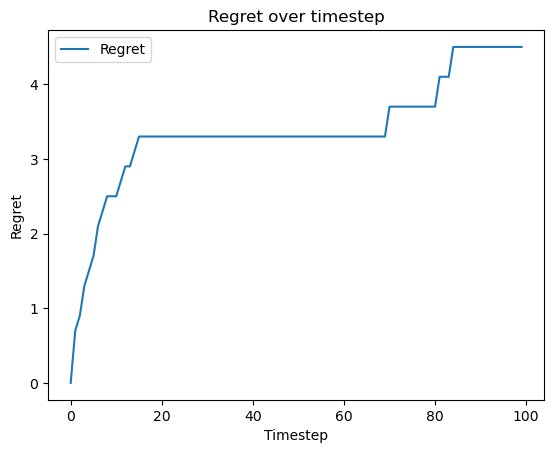

Total Regret after Thompson Algorithm 100 timesteps: 11.1 with assumed best arm 0


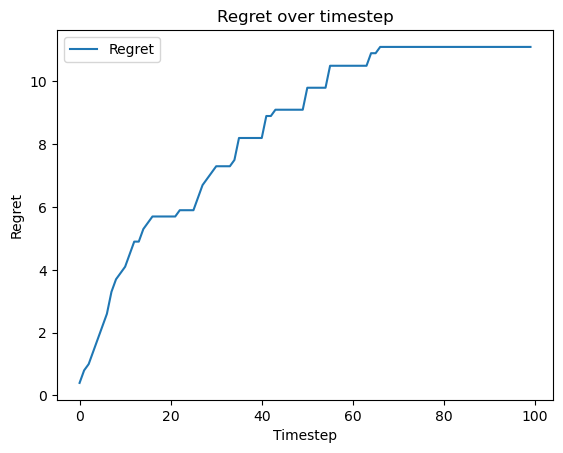

Total Regret for UCB algorithm after 100 timesteps: 1.7000000000000002 with assumed best arm 0


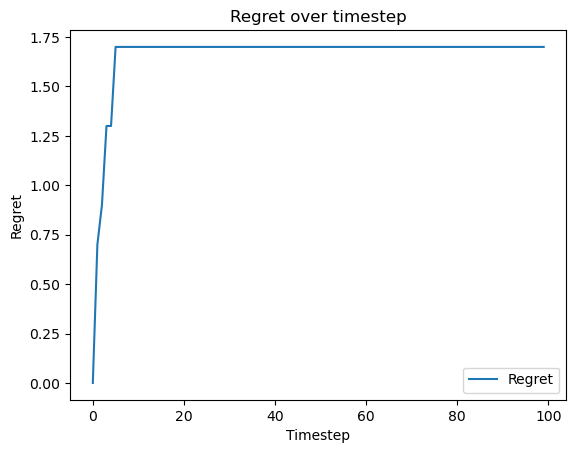

In [381]:
bandit = MultiBandit()
# bandit = MultiBandit([0.9, 0.5, 0.1, 0.3, 0.4])   # Make custom Multi-armed Bandit. Should work while grading code

H = 100

algorithm1 = EpsilonGreedyAlgorithm(num_arms=bandit.num_arms(), horizon=H, epsilon=0.05)
algorithm1.run_algorithm(bandit)
print(f"Total Regret for epsilon greedy algorithm after {H} timesteps: {bandit.regret()} with assumed best arm {algorithm.give_best_arm()}")
algorithm.plot()

bandit.set_regret()

algorithm2 = ThompsonAlgorithm(num_arms=bandit.num_arms(), horizon=H)
algorithm2.run_algorithm(bandit)
print(f"Total Regret after Thompson Algorithm {H} timesteps: {bandit.regret()} with assumed best arm {algorithm.give_best_arm()}")
algorithm2.plot()
bandit.set_regret()

algorithm3 = UCB(num_arms=bandit.num_arms(), horizon=H)
algorithm3.run_algorithm(bandit)
print(f"Total Regret for UCB algorithm after {H} timesteps: {bandit.regret()} with assumed best arm {algorithm.give_best_arm()}")
algorithm3.plot()